In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
random.seed(134)
import pandas as pd
import spacy
import string
from sklearn.model_selection import train_test_split
PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32
MAX_SENT_LENGTH = 25
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.init as I
import pandas as pd

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
train_data = pd.read_csv('snli_train.tsv',sep = '\t')
val_data = pd.read_csv('snli_val.tsv',sep = '\t')

In [4]:
def build_vocab(data):
    all_tokens = compute_all_tokens(data)
    token_counter = Counter(all_tokens)
#     print(token_counter)
    vocab = token_counter.keys()
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<PAD>', '<UNK>'] + id2token
    token2id['<PAD>'] = PAD_IDX 
    token2id['<UNK>'] = UNK_IDX
    return token2id, id2token

In [5]:
punctuations = string.punctuation
def tokenize(sent):
    tokens = sent.split()
    return [token for token in tokens]

In [6]:
def compute_all_tokens(data):
    all_tokens_list = []
    temp1 = data['sentence1'].apply(tokenize)
    temp2 = data['sentence2'].apply(tokenize)
    for i in temp1:
        all_tokens_list += i
    for i in temp2:
        all_tokens_list += i
    return all_tokens_list

In [7]:
token2id, id2token = build_vocab(train_data)

In [8]:
token2id['<PAD>']

0

In [9]:
words_to_load = 200000

import numpy as np

with open('/scratch/ark576/fasttext/crawl-300d-2M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load+2, 300))
    words = {}
    idx2words = {}
    ordered_words = []
    idx2words[0] = '<PAD>'
    idx2words[1] = '<UNK>'
    ordered_words.append('<PAD>')
    ordered_words.append('<UNK>')
    words['<PAD>'] = 0
    words['<UNK>'] = 1
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings[i+2, :] = np.asarray(s[1:])
        words[s[0]] = i+2
        idx2words[i+2] = s[0]
        ordered_words.append(s[0])

In [10]:
def filtered_vocab(token2id, id2token, ordered_words):
    new_token2id = {}
    new_id2token = []
    words = set(ordered_words)
    for w in id2token:
        if w in words:
            new_id2token.append(w)
            new_token2id[w] = len(new_id2token)-1
    return new_token2id, new_id2token

In [11]:
new_token2id, new_id2token = filtered_vocab(token2id,id2token,ordered_words)

In [12]:
def build_embedding_mat(id2token):
    new_embeddings = np.zeros((len(id2token),300))
    for i,w in enumerate(id2token):
        new_embeddings[i,:] = loaded_embeddings[words[w]]
    return new_embeddings
    

In [13]:
new_embeddings = build_embedding_mat(new_id2token)

In [14]:
new_embeddings.shape

(20523, 300)

In [15]:
vocab_words = set(new_id2token)
def idxize_sent(tokens, words = new_token2id):
    idx_list = []
    for w in tokens:
        if w in vocab_words:
            idx_list.append(words[w])
        else:
            idx_list.append(words['<UNK>'])
    return idx_list

In [16]:
def preprocess_data_set(data):
    print('Tokenizing Sentence')
    data['sent1_tokenize'] = data['sentence1'].apply(tokenize)
    data['sent2_tokenize'] = data['sentence2'].apply(tokenize)
    print('Tokenizing finished, saving the lengths of sentences')
    data['sent1_len'] = data['sent1_tokenize'].apply(len)
    data['sent2_len'] = data['sent2_tokenize'].apply(len)
    print('Lenghts saved, Converting tokens to idx')
    data['sent1_idx'] = data['sent1_tokenize'].apply(idxize_sent)
    data['sent2_idx'] = data['sent2_tokenize'].apply(idxize_sent)
    print('Conversion completed, Mapping Labels to int')
    mapping = {'contradiction':0,'neutral':1,'entailment':2}
    data['label_idx'] = data['label'].map(mapping)
    return data

In [17]:
def idx_to_vect(idxs):
    list_word_vec = []
    for i in idxs:
        list_word_vec.append(loaded_embeddings[i])
    return np.vstack(list_word_vec)

In [18]:
train_data = preprocess_data_set(train_data)

Tokenizing Sentence
Tokenizing finished, saving the lengths of sentences
Lenghts saved, Converting tokens to idx
Conversion completed, Mapping Labels to int


In [19]:
train_data.head()

,sentence1,sentence2,label,sent1_tokenize,sent2_tokenize,sent1_len,sent2_len,sent1_idx,sent2_idx,label_idx
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral,"[A, young, girl, in, a, pink, shirt, sitting, ...","[A, young, girl, watching, the, sunset, over, ...",17,10,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 6, 11, 12, 6, 13,...","[2, 3, 4, 564, 21, 1364, 98, 21, 15, 16]",1
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment,"[A, woman, is, smiling, while, the, man, next,...","[Two, people, are, next, to, each, other, .]",22,8,"[2, 17, 18, 19, 20, 21, 22, 23, 24, 25, 18, 26...","[78, 76, 101, 23, 24, 269, 270, 16]",2
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral,"[Across, the, river, ,, you, can, see, a, larg...","[The, large, building, is, full, of, apartment...",11,9,"[32, 21, 33, 34, 35, 36, 37, 6, 38, 39, 16]","[95, 38, 39, 18, 1630, 14, 14668, 42, 15354]",1
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction,"[a, man, in, white, shorts, and, a, black, shi...","[A, man, is, riding, a, jetski, on, the, ocean...",14,10,"[6, 22, 5, 40, 41, 42, 6, 43, 8, 18, 44, 10, 2...","[2, 22, 18, 69, 6, 15355, 10, 21, 45, 16]",0
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction,"[Four, black, dogs, run, together, on, bright,...","[Four, dogs, are, preparing, to, be, launched,...",10,10,"[46, 43, 47, 48, 49, 10, 50, 51, 52, 16]","[46, 47, 101, 1322, 24, 650, 6869, 241, 2571, 16]",0


In [20]:
val_data = preprocess_data_set(val_data)

Tokenizing Sentence
Tokenizing finished, saving the lengths of sentences
Lenghts saved, Converting tokens to idx
Conversion completed, Mapping Labels to int


In [21]:
# train_data, val_data = train_test_split(data, test_size = 0.2, stratify = data['label'])

In [22]:
# pickling(train_data,'train_SNLI_data.p')

In [23]:
# pickling(val_data,'val_SNLI_data.p')

In [24]:
def check_1s(x):
    if 1 in set(x):
        return 1
    else:
        return 0

In [25]:
a = train_data['sent2_idx'].apply(check_1s)

In [26]:
np.sum(a)/a.shape[0]

0.02633

In [37]:
MAX_SENTENCE_LENGTH = 50

import numpy as np
import torch
from torch.utils.data import Dataset

class SNLI(Dataset):
    
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, key):
        data_name = self.df.iloc[key].name
        sent1_idxs = self.df['sent1_idx'].iloc[key][:MAX_SENTENCE_LENGTH]
        m_sent1 = np.array(sent1_idxs)==1
        sent2_idxs = self.df['sent2_idx'].iloc[key][:MAX_SENTENCE_LENGTH]
        m_sent2 = np.array(sent2_idxs)==1
#         sent1_vec = torch.from_numpy(idx_to_vect(sent1_idxs)).type(torch.FloatTensor)
#         sent2_vec = torch.from_numpy(idx_to_vect(sent2_idxs)).type(torch.FloatTensor)
        label = self.df['label_idx'].iloc[key]
        return [sent1_idxs,sent2_idxs, len(sent1_idxs),len(sent2_idxs), int(label),data_name,m_sent1,m_sent2]

def SNLI_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    sent1_list = []
    sent2_list = []
    label_list = []
    sent1_length_list = []
    sent2_length_list = []
    data_name_list = []
    m_sent1_list = []
    m_sent2_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[4])
        sent1_length_list.append(datum[2])
        sent2_length_list.append(datum[3])
        data_name_list.append(datum[5])
    # padding
    for datum in batch:
        padded_sent1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        padded_sent2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        padded_m_sent1 = np.pad(np.array(datum[6]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        padded_m_sent2 = np.pad(np.array(datum[7]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        sent1_list.append(padded_sent1)
        sent2_list.append(padded_sent2)
        m_sent1_list.append(padded_m_sent1)
        m_sent2_list.append(padded_m_sent2)
    ind_dec_order = np.argsort(sent1_length_list)[::-1]
    sent1_list = np.array(sent1_list)[ind_dec_order].astype(int)
    sent2_list = np.array(sent2_list)[ind_dec_order].astype(int)
    sent1_length_list = np.array(sent1_length_list)[ind_dec_order]
    sent2_length_list = np.array(sent2_length_list)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    m_sent1_list = np.array(m_sent1_list)[ind_dec_order].astype(float)
    m_sent2_list = np.array(m_sent2_list)[ind_dec_order].astype(float)
    data_name_list = np.array(data_name_list)[ind_dec_order]
    return [torch.from_numpy(np.array(sent1_list)),torch.from_numpy(np.array(sent2_list)), \
            torch.LongTensor(sent1_length_list),torch.LongTensor(sent2_length_list),torch.LongTensor(label_list),\
           data_name_list, torch.FloatTensor(m_sent1_list),torch.FloatTensor(m_sent2_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 128
train_dataset = SNLI(train_data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

val_dataset = SNLI(val_data)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=SNLI_collate_func,
                                           shuffle=True)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [38]:
for i, (j) in enumerate(train_loader):
    print (j[0].size())
    print (j[1].size())
    print (j[2].size())
    print (j[3].size())
    print (j[4].size())
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])
torch.Size([128])
torch.Size([128])


In [66]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, dropout, vocab_size = new_embeddings.shape[0],):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(new_embeddings).cuda(), freeze = True)
        self.embedding.weight.requires_grad = True
        self.gru = nn.GRU(emb_size, hidden_size, 2, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(2*hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)
        self.dropout = dropout

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.zeros(2*2, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x1,x2,len1,len2,m1,m2):
        # reset hidden state

        batch_size, seq_len = x1.size()

        self.hidden = self.init_hidden(batch_size)
        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
#         embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, len1.numpy(), batch_first=True)
#         embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, len2.numpy(), batch_first=True)
        # fprop though RNN
        _, h1 = self.gru(embed1, self.hidden)
#         self.hidden = self.init_hidden(batch_size)
        _, h2 = self.gru(embed2, self.hidden)
        # undo packing
#         gru_out_1, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_1, batch_first=True)
#         gru_out_2, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_2, batch_first=True)
        # sum hidden activations of RNN across time
#         gru_out_1 = torch.sum(gru_out_1, dim = 1)
#         gru_out_2 = torch.sum(gru_out_2, dim = 1)
        
#         print(h1.size())
#         print(h2.size())
        h1 = torch.sum(h1,dim = 0)
        h2 = torch.sum(h2,dim = 0)
        #cat hidden rep
        x = torch.cat([h1,h2],dim = 1)
        x = F.dropout(F.relu(self.linear1(x)),p = self.dropout)
        x = self.linear2(x)
        return x

In [30]:
def init_weights(m):
    if (type(m) == nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)
#     if type(m) == nn.GRU:
#         torch.nn.init.xavier_normal_(m.weight_hh_l0_reverse)
#         torch.nn.init.xavier_normal_(m.weight_ih_l0_reverse)
#         torch.nn.init.xavier_normal_(m.weight_hh_l0)
#         torch.nn.init.xavier_normal_(m.weight_ih_l0)

In [31]:
def test_model(loader, model, criterion):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    predictions = []
    for batch in loader:
        out = model(batch[0].cuda(), batch[1].cuda(), batch[2],batch[3], batch[6].cuda(),batch[7].cuda())
        outputs = F.softmax(out, dim=1)
        predicted = outputs.max(1, keepdim=True)[1].cpu()
        loss = criterion(outputs,batch[4].cuda())
        total += batch[4].size(0)
        correct += predicted.eq(batch[4].view_as(predicted)).sum().item()
        predictions.append((batch[5],predicted.squeeze().numpy(),batch[4].numpy()))
    return (100 * correct / total), loss.item(), np.concatenate(predictions,axis = 1).T

In [32]:
mask = np.zeros(new_embeddings.shape[0])
mask[1] = 1
def train_model(model,criterion,optimizer,name, num_epochs = 5):

    loss_dict = {'train':[],'val':[]}
    acc_dict = {'train':[],'val':[]}
    best_acc = 0
    best_pred = None
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for i, (batch) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(batch[0].cuda(), batch[1].cuda(), batch[2],batch[3],batch[6].cuda(),batch[7].cuda())
            loss = criterion(outputs, batch[4].cuda())
            loss.backward()
            model.embedding.weight.grad[torch.from_numpy(mask) == 0]=0
            optimizer.step()
            out = F.softmax(outputs, dim=1)
            if i>0 and i%100 == 0:
                predicted = out.max(1, keepdim=True)[1]
                total += batch[4].size(0)
                correct += predicted.eq(batch[4].cuda().view_as(predicted)).sum().item()
                loss_dict['train'].append(loss.item())
                acc_dict['train'].append((100 * correct / total))
    #         loss_2 = criterion2(torch.round(outputs[1]), label_rat_batch)
    #         loss = loss_2
            # validate every 100 iterations
            if i>0 and i%100 == 0:
                # validate
                val_acc, val_loss,pred= test_model(val_loader, model, criterion)
                loss_dict['val'].append(val_loss)
                acc_dict['val'].append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                                   epoch+1, num_epochs, i+1, len(train_loader), val_acc))
                if val_acc > best_acc:
                    torch.save(model,'/scratch/ark576/NLP_HW_2/'+name)
                    best_pred = pred
                    best_acc = val_acc
                    best_wts = model.state_dict()
    print('Best Accuracy:{}'.format(best_acc))
    pickling(loss_dict,'/scratch/ark576/NLP_HW_2/'+name+'_loss_hist')
    pickling(acc_dict,'/scratch/ark576/NLP_HW_2/'+name+'_acc_hist')
    pickling(best_pred,'/scratch/ark576/NLP_HW_2/'+name+'_preds')
    model.load_state_dict(best_wts)
    return model, loss_dict, acc_dict, best_pred

# GRU type 1

In [199]:
gru = GRU(300,300).cuda()

In [180]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [181]:
criterion = nn.CrossEntropyLoss()

In [182]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=300_dp=0.5',num_epochs=10)

Epoch: [1/10], Step: [101/2500], Validation Acc: 42.84


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/10], Step: [201/2500], Validation Acc: 48.8
Epoch: [1/10], Step: [301/2500], Validation Acc: 50.52
Epoch: [1/10], Step: [401/2500], Validation Acc: 52.935
Epoch: [1/10], Step: [501/2500], Validation Acc: 53.54
Epoch: [1/10], Step: [601/2500], Validation Acc: 54.87
Epoch: [1/10], Step: [701/2500], Validation Acc: 56.615
Epoch: [1/10], Step: [801/2500], Validation Acc: 56.965
Epoch: [1/10], Step: [901/2500], Validation Acc: 57.175
Epoch: [1/10], Step: [1001/2500], Validation Acc: 57.675
Epoch: [1/10], Step: [1101/2500], Validation Acc: 55.355
Epoch: [1/10], Step: [1201/2500], Validation Acc: 58.7
Epoch: [1/10], Step: [1301/2500], Validation Acc: 58.715
Epoch: [1/10], Step: [1401/2500], Validation Acc: 58.42
Epoch: [1/10], Step: [1501/2500], Validation Acc: 59.95
Epoch: [1/10], Step: [1601/2500], Validation Acc: 60.37
Epoch: [1/10], Step: [1701/2500], Validation Acc: 61.215
Epoch: [1/10], Step: [1801/2500], Validation Acc: 60.92
Epoch: [1/10], Step: [1901/2500], Validation Acc: 

Epoch: [7/10], Step: [501/2500], Validation Acc: 64.945
Epoch: [7/10], Step: [601/2500], Validation Acc: 65.12
Epoch: [7/10], Step: [701/2500], Validation Acc: 65.145
Epoch: [7/10], Step: [801/2500], Validation Acc: 65.18
Epoch: [7/10], Step: [901/2500], Validation Acc: 64.965
Epoch: [7/10], Step: [1001/2500], Validation Acc: 64.555
Epoch: [7/10], Step: [1101/2500], Validation Acc: 64.805
Epoch: [7/10], Step: [1201/2500], Validation Acc: 65.1
Epoch: [7/10], Step: [1301/2500], Validation Acc: 65.16
Epoch: [7/10], Step: [1401/2500], Validation Acc: 64.92
Epoch: [7/10], Step: [1501/2500], Validation Acc: 65.295
Epoch: [7/10], Step: [1601/2500], Validation Acc: 65.075
Epoch: [7/10], Step: [1701/2500], Validation Acc: 64.82
Epoch: [7/10], Step: [1801/2500], Validation Acc: 65.145
Epoch: [7/10], Step: [1901/2500], Validation Acc: 64.935
Epoch: [7/10], Step: [2001/2500], Validation Acc: 64.54
Epoch: [7/10], Step: [2101/2500], Validation Acc: 64.845
Epoch: [7/10], Step: [2201/2500], Validation

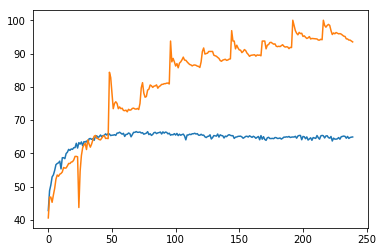

In [183]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')

In [191]:
np.concatenate(best_pred_gru,axis = 1).T

array([[98060, 80921, 33315, ..., 32693, 15638, 48647],
       [    1,     0,     1, ...,     1,     2,     2],
       [    2,     0,     0, ...,     0,     0,     1]])

# GRU type 2 (n = 300), dp = 0, Max_len = 50, cating the h's

In [51]:
gru = GRU(300,300, dropout=0).cuda()

In [46]:
new_embeddings.shape

(20523, 300)

In [52]:
count_parameters(gru) - 20522*300

2888703

In [49]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(20523, 300, padding_idx=0)
  (gru): GRU(300, 300, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=600, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=3, bias=True)
)

In [50]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [51]:
criterion = nn.CrossEntropyLoss()

In [52]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=300_t2_dp=0_max_len=50_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 53.0
Epoch: [1/10], Step: [201/782], Validation Acc: 57.9
Epoch: [1/10], Step: [301/782], Validation Acc: 56.2
Epoch: [1/10], Step: [401/782], Validation Acc: 58.6
Epoch: [1/10], Step: [501/782], Validation Acc: 60.1
Epoch: [1/10], Step: [601/782], Validation Acc: 60.5
Epoch: [1/10], Step: [701/782], Validation Acc: 64.0
Epoch: [2/10], Step: [101/782], Validation Acc: 63.7
Epoch: [2/10], Step: [201/782], Validation Acc: 62.8
Epoch: [2/10], Step: [301/782], Validation Acc: 65.6
Epoch: [2/10], Step: [401/782], Validation Acc: 65.9
Epoch: [2/10], Step: [501/782], Validation Acc: 64.3
Epoch: [2/10], Step: [601/782], Validation Acc: 67.3
Epoch: [2/10], Step: [701/782], Validation Acc: 65.6
Epoch: [3/10], Step: [101/782], Validation Acc: 66.8
Epoch: [3/10], Step: [201/782], Validation Acc: 66.2
Epoch: [3/10], Step: [301/782], Validation Acc: 66.7
Epoch: [3/10], Step: [401/782], Validation Acc: 66.8
Epoch: [3/10], Step: [501/782], Validation Acc

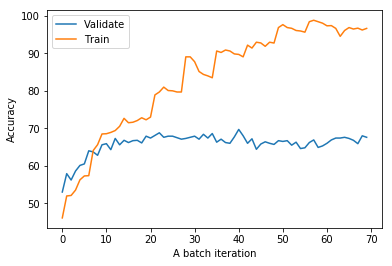

In [53]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

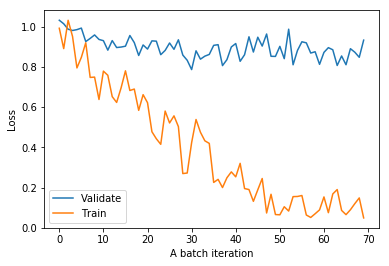

In [54]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# GRU type 2 (n = 50), dp = 0, Max_len = 50, cating the h's

In [67]:
gru = GRU(300,50, dropout=0).cuda()

In [68]:
count_parameters(gru) - 20522*300

156703

In [56]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(20523, 300, padding_idx=0)
  (gru): GRU(300, 50, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=100, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=3, bias=True)
)

In [57]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [58]:
criterion = nn.CrossEntropyLoss()

In [59]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=50_t2_dp=0_max_len=50_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 45.1
Epoch: [1/10], Step: [201/782], Validation Acc: 52.7
Epoch: [1/10], Step: [301/782], Validation Acc: 56.8
Epoch: [1/10], Step: [401/782], Validation Acc: 58.5
Epoch: [1/10], Step: [501/782], Validation Acc: 59.2
Epoch: [1/10], Step: [601/782], Validation Acc: 59.5
Epoch: [1/10], Step: [701/782], Validation Acc: 57.8
Epoch: [2/10], Step: [101/782], Validation Acc: 61.9
Epoch: [2/10], Step: [201/782], Validation Acc: 61.4
Epoch: [2/10], Step: [301/782], Validation Acc: 61.2
Epoch: [2/10], Step: [401/782], Validation Acc: 62.3
Epoch: [2/10], Step: [501/782], Validation Acc: 63.4
Epoch: [2/10], Step: [601/782], Validation Acc: 62.2
Epoch: [2/10], Step: [701/782], Validation Acc: 63.4
Epoch: [3/10], Step: [101/782], Validation Acc: 64.1
Epoch: [3/10], Step: [201/782], Validation Acc: 63.5
Epoch: [3/10], Step: [301/782], Validation Acc: 63.9
Epoch: [3/10], Step: [401/782], Validation Acc: 64.2
Epoch: [3/10], Step: [501/782], Validation Acc

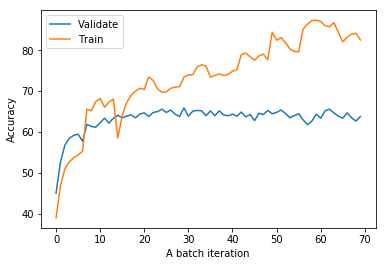

In [60]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

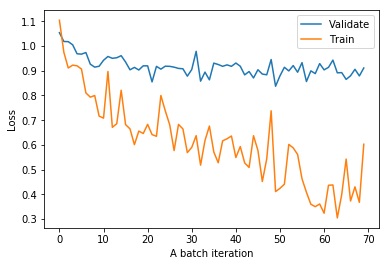

In [61]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# GRU type 2 (n = 300), dp = 0.5

In [256]:
gru = GRU(300,300,dropout = 0.5).cuda()

In [257]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [258]:
criterion = nn.CrossEntropyLoss()

In [259]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=300_t2_dp=0_5',num_epochs=7)

Epoch: [1/7], Step: [101/2500], Validation Acc: 44.445
Epoch: [1/7], Step: [201/2500], Validation Acc: 50.115
Epoch: [1/7], Step: [301/2500], Validation Acc: 52.885
Epoch: [1/7], Step: [401/2500], Validation Acc: 54.585
Epoch: [1/7], Step: [501/2500], Validation Acc: 54.105
Epoch: [1/7], Step: [601/2500], Validation Acc: 55.18
Epoch: [1/7], Step: [701/2500], Validation Acc: 57.005
Epoch: [1/7], Step: [801/2500], Validation Acc: 56.655
Epoch: [1/7], Step: [901/2500], Validation Acc: 57.32
Epoch: [1/7], Step: [1001/2500], Validation Acc: 57.335
Epoch: [1/7], Step: [1101/2500], Validation Acc: 59.56
Epoch: [1/7], Step: [1201/2500], Validation Acc: 58.955
Epoch: [1/7], Step: [1301/2500], Validation Acc: 59.885
Epoch: [1/7], Step: [1401/2500], Validation Acc: 60.22
Epoch: [1/7], Step: [1501/2500], Validation Acc: 60.205
Epoch: [1/7], Step: [1601/2500], Validation Acc: 61.565
Epoch: [1/7], Step: [1701/2500], Validation Acc: 61.375
Epoch: [1/7], Step: [1801/2500], Validation Acc: 61.725
Epoch

Epoch: [7/7], Step: [601/2500], Validation Acc: 63.665
Epoch: [7/7], Step: [701/2500], Validation Acc: 63.06
Epoch: [7/7], Step: [801/2500], Validation Acc: 63.65
Epoch: [7/7], Step: [901/2500], Validation Acc: 63.135
Epoch: [7/7], Step: [1001/2500], Validation Acc: 63.445
Epoch: [7/7], Step: [1101/2500], Validation Acc: 63.03
Epoch: [7/7], Step: [1201/2500], Validation Acc: 63.04
Epoch: [7/7], Step: [1301/2500], Validation Acc: 63.56
Epoch: [7/7], Step: [1401/2500], Validation Acc: 63.785
Epoch: [7/7], Step: [1501/2500], Validation Acc: 63.645
Epoch: [7/7], Step: [1601/2500], Validation Acc: 63.18
Epoch: [7/7], Step: [1701/2500], Validation Acc: 63.63
Epoch: [7/7], Step: [1801/2500], Validation Acc: 63.21
Epoch: [7/7], Step: [1901/2500], Validation Acc: 63.33
Epoch: [7/7], Step: [2001/2500], Validation Acc: 63.205
Epoch: [7/7], Step: [2101/2500], Validation Acc: 62.755
Epoch: [7/7], Step: [2201/2500], Validation Acc: 63.275
Epoch: [7/7], Step: [2301/2500], Validation Acc: 63.095
Epoch

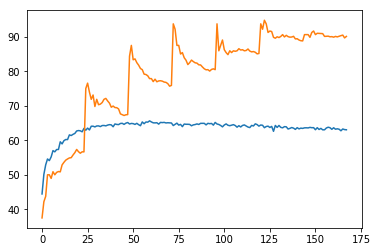

In [260]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')

# GRU type 2 (n = 300), dp = 0.5, Max_len = 50, cating the h's

In [53]:
gru = GRU(300,300,dropout = 0.5).cuda()

In [54]:
count_parameters(gru) - 20522*300

2888703

In [63]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(20523, 300, padding_idx=0)
  (gru): GRU(300, 300, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=600, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=3, bias=True)
)

In [64]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [65]:
criterion = nn.CrossEntropyLoss()

In [66]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=300_t2_dp=0_5_max_len=50_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 53.5
Epoch: [1/10], Step: [201/782], Validation Acc: 55.8
Epoch: [1/10], Step: [301/782], Validation Acc: 57.6
Epoch: [1/10], Step: [401/782], Validation Acc: 59.4
Epoch: [1/10], Step: [501/782], Validation Acc: 61.3
Epoch: [1/10], Step: [601/782], Validation Acc: 60.8
Epoch: [1/10], Step: [701/782], Validation Acc: 62.3
Epoch: [2/10], Step: [101/782], Validation Acc: 64.1
Epoch: [2/10], Step: [201/782], Validation Acc: 63.6
Epoch: [2/10], Step: [301/782], Validation Acc: 65.2
Epoch: [2/10], Step: [401/782], Validation Acc: 65.9
Epoch: [2/10], Step: [501/782], Validation Acc: 67.3
Epoch: [2/10], Step: [601/782], Validation Acc: 66.7
Epoch: [2/10], Step: [701/782], Validation Acc: 66.7
Epoch: [3/10], Step: [101/782], Validation Acc: 66.8
Epoch: [3/10], Step: [201/782], Validation Acc: 65.9
Epoch: [3/10], Step: [301/782], Validation Acc: 66.0
Epoch: [3/10], Step: [401/782], Validation Acc: 67.2
Epoch: [3/10], Step: [501/782], Validation Acc

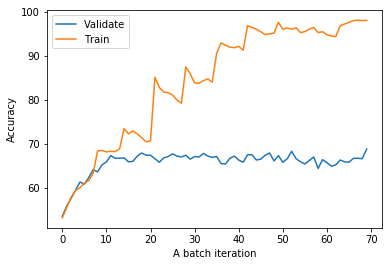

In [67]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

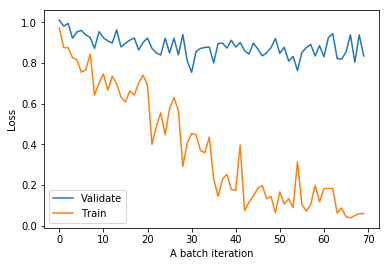

In [68]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# GRU type 2 (n = 400), dp = 0, Max_len = 50, cating the h's

In [55]:
gru = GRU(300,400,dropout = 0).cuda()

In [56]:
count_parameters(gru) - 20522*300

4891503

In [70]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(20523, 300, padding_idx=0)
  (gru): GRU(300, 400, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=800, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=3, bias=True)
)

In [71]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [72]:
criterion = nn.CrossEntropyLoss()

In [73]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=400_t2_dp=0_max_len=50_cath',num_epochs=7)

Epoch: [2/7], Step: [201/782], Validation Acc: 65.0
Epoch: [2/7], Step: [301/782], Validation Acc: 63.5
Epoch: [2/7], Step: [401/782], Validation Acc: 63.6
Epoch: [2/7], Step: [501/782], Validation Acc: 64.4
Epoch: [2/7], Step: [601/782], Validation Acc: 66.9
Epoch: [2/7], Step: [701/782], Validation Acc: 64.0
Epoch: [3/7], Step: [101/782], Validation Acc: 66.3
Epoch: [3/7], Step: [201/782], Validation Acc: 67.5
Epoch: [3/7], Step: [301/782], Validation Acc: 66.0
Epoch: [3/7], Step: [401/782], Validation Acc: 66.0
Epoch: [3/7], Step: [501/782], Validation Acc: 67.7
Epoch: [3/7], Step: [601/782], Validation Acc: 66.8
Epoch: [3/7], Step: [701/782], Validation Acc: 67.2
Epoch: [4/7], Step: [101/782], Validation Acc: 66.7
Epoch: [4/7], Step: [201/782], Validation Acc: 68.1
Epoch: [4/7], Step: [301/782], Validation Acc: 65.8
Epoch: [4/7], Step: [401/782], Validation Acc: 66.7
Epoch: [4/7], Step: [501/782], Validation Acc: 66.3
Epoch: [4/7], Step: [601/782], Validation Acc: 67.1
Epoch: [4/7]

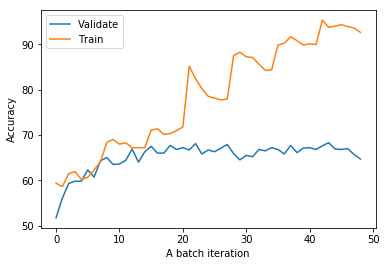

In [74]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

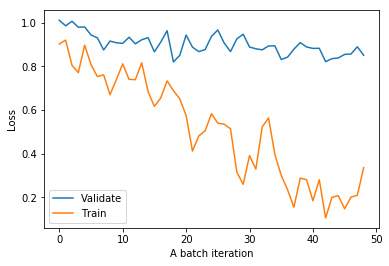

In [75]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# GRU type 2 (n = 500), dp = 0, Max_len = 50, cating the h's

In [57]:
gru = GRU(300,500,dropout = 0).cuda()

In [58]:
count_parameters(gru) - 20522*300

7414303

In [77]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(20523, 300, padding_idx=0)
  (gru): GRU(300, 500, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=1000, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
)

In [78]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [79]:
criterion = nn.CrossEntropyLoss()

In [80]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=500_t2_dp=0_max_len=50_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 47.1
Epoch: [1/10], Step: [201/782], Validation Acc: 55.3
Epoch: [1/10], Step: [301/782], Validation Acc: 59.2
Epoch: [1/10], Step: [401/782], Validation Acc: 59.1
Epoch: [1/10], Step: [501/782], Validation Acc: 59.0
Epoch: [1/10], Step: [601/782], Validation Acc: 62.7
Epoch: [1/10], Step: [701/782], Validation Acc: 62.8
Epoch: [2/10], Step: [101/782], Validation Acc: 65.2
Epoch: [2/10], Step: [201/782], Validation Acc: 64.8
Epoch: [2/10], Step: [301/782], Validation Acc: 63.9
Epoch: [2/10], Step: [401/782], Validation Acc: 65.5
Epoch: [2/10], Step: [501/782], Validation Acc: 65.4
Epoch: [2/10], Step: [601/782], Validation Acc: 64.8
Epoch: [2/10], Step: [701/782], Validation Acc: 66.3
Epoch: [3/10], Step: [101/782], Validation Acc: 68.2
Epoch: [3/10], Step: [201/782], Validation Acc: 67.1
Epoch: [3/10], Step: [301/782], Validation Acc: 67.6
Epoch: [3/10], Step: [401/782], Validation Acc: 67.8
Epoch: [3/10], Step: [501/782], Validation Acc

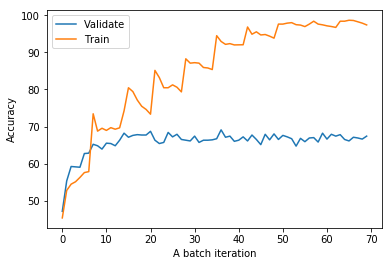

In [81]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

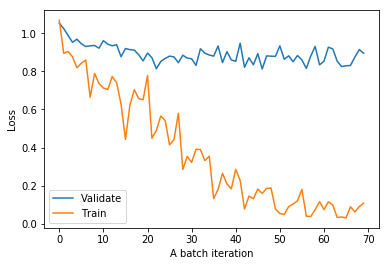

In [82]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# GRU element-wise multiplication

In [59]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, dropout, vocab_size = new_embeddings.shape[0],):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(new_embeddings).cuda(), freeze = False)
        self.embedding.weight.requires_grad = True
        self.gru = nn.GRU(emb_size, hidden_size, 1, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)
        self.dropout = dropout

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(1*2, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x1,x2,len1,len2,m1,m2):
        # reset hidden state

        batch_size, seq_len = x1.size()

        self.hidden = self.init_hidden(batch_size)

        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
#         embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, len1.numpy(), batch_first=True)
#         embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, len2.numpy(), batch_first=True)
        # fprop though RNN
        _, h1 = self.gru(embed1, self.hidden)
        _, h2 = self.gru(embed2, self.hidden)
        # undo packing
#         gru_out_1, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_1, batch_first=True)
#         gru_out_2, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_2, batch_first=True)
        # sum hidden activations of RNN across time
#         gru_out_1 = torch.sum(gru_out_1, dim = 1)
#         gru_out_2 = torch.sum(gru_out_2, dim = 1)
        
#         print(h1.size())
#         print(h2.size())
        h1 = torch.sum(h1,dim = 0)
        h2 = torch.sum(h2,dim = 0)
        #cat hidden rep
        x = h1*h2
        x = F.dropout(F.relu(self.linear1(x)),p = self.dropout)
        x = self.linear2(x)
        return x

# GRU type 2 (n = 300), dp = 0, Max_len = 50, elements wise mult

In [60]:
gru = GRU(300,300,dropout = 0).cuda()

In [61]:
count_parameters(gru) - 20522*300

1175103

In [85]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(20523, 300, padding_idx=0)
  (gru): GRU(300, 300, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=300, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=3, bias=True)
)

In [86]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [87]:
criterion = nn.CrossEntropyLoss()

In [88]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=300_t2_dp=0_max_len=25_multh',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 45.6
Epoch: [1/10], Step: [201/782], Validation Acc: 51.6
Epoch: [1/10], Step: [301/782], Validation Acc: 57.7
Epoch: [1/10], Step: [401/782], Validation Acc: 58.6
Epoch: [1/10], Step: [501/782], Validation Acc: 59.7
Epoch: [1/10], Step: [601/782], Validation Acc: 63.8
Epoch: [1/10], Step: [701/782], Validation Acc: 63.5
Epoch: [2/10], Step: [101/782], Validation Acc: 65.4
Epoch: [2/10], Step: [201/782], Validation Acc: 66.5
Epoch: [2/10], Step: [301/782], Validation Acc: 67.9
Epoch: [2/10], Step: [401/782], Validation Acc: 67.0
Epoch: [2/10], Step: [501/782], Validation Acc: 66.8
Epoch: [2/10], Step: [601/782], Validation Acc: 67.4
Epoch: [2/10], Step: [701/782], Validation Acc: 67.5
Epoch: [3/10], Step: [101/782], Validation Acc: 68.0
Epoch: [3/10], Step: [201/782], Validation Acc: 67.8
Epoch: [3/10], Step: [301/782], Validation Acc: 67.4
Epoch: [3/10], Step: [401/782], Validation Acc: 68.1
Epoch: [3/10], Step: [501/782], Validation Acc

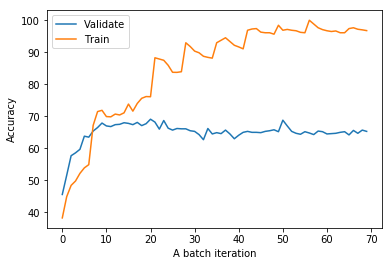

In [89]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

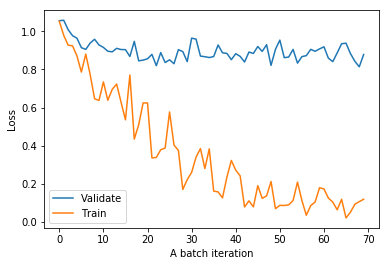

In [90]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# GRU type 2 (n = 400), dp = 0, Max_len = 50, elements wise mult

In [62]:
gru = GRU(300,400,dropout = 0).cuda()

In [63]:
count_parameters(gru) - 20522*300

1846703

In [92]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(20523, 300, padding_idx=0)
  (gru): GRU(300, 400, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=400, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=3, bias=True)
)

In [93]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [94]:
criterion = nn.CrossEntropyLoss()

In [95]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=400_t2_dp=0_max_len=25_multh',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 49.1
Epoch: [1/10], Step: [201/782], Validation Acc: 52.8
Epoch: [1/10], Step: [301/782], Validation Acc: 58.0
Epoch: [1/10], Step: [401/782], Validation Acc: 61.0
Epoch: [1/10], Step: [501/782], Validation Acc: 60.2
Epoch: [1/10], Step: [601/782], Validation Acc: 61.7
Epoch: [1/10], Step: [701/782], Validation Acc: 64.2
Epoch: [2/10], Step: [101/782], Validation Acc: 65.5
Epoch: [2/10], Step: [201/782], Validation Acc: 65.5
Epoch: [2/10], Step: [301/782], Validation Acc: 67.4
Epoch: [2/10], Step: [401/782], Validation Acc: 66.9
Epoch: [2/10], Step: [501/782], Validation Acc: 69.8
Epoch: [2/10], Step: [601/782], Validation Acc: 66.9
Epoch: [2/10], Step: [701/782], Validation Acc: 67.1
Epoch: [3/10], Step: [101/782], Validation Acc: 68.1
Epoch: [3/10], Step: [201/782], Validation Acc: 66.9
Epoch: [3/10], Step: [301/782], Validation Acc: 66.3
Epoch: [3/10], Step: [401/782], Validation Acc: 66.6
Epoch: [3/10], Step: [501/782], Validation Acc

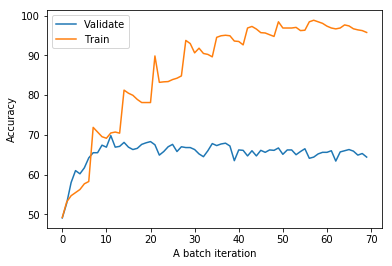

In [96]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

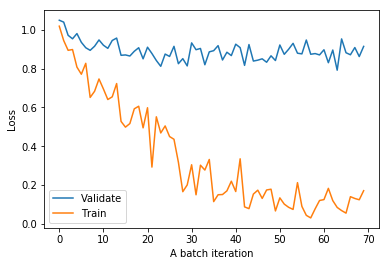

In [97]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# GRU type 2 (n = 500), dp = 0, Max_len = 50, elements wise mult

In [64]:
gru = GRU(300,500,dropout = 0).cuda()

In [65]:
count_parameters(gru) - 20522*300

2658303

In [99]:
gru.apply(init_weights)

GRU(
  (embedding): Embedding(20523, 300, padding_idx=0)
  (gru): GRU(300, 500, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=500, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=3, bias=True)
)

In [100]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [101]:
criterion = nn.CrossEntropyLoss()

In [102]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=500_t2_dp=0_max_len=25_multh',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 49.1
Epoch: [1/10], Step: [201/782], Validation Acc: 55.1
Epoch: [1/10], Step: [301/782], Validation Acc: 60.3
Epoch: [1/10], Step: [401/782], Validation Acc: 61.9
Epoch: [1/10], Step: [501/782], Validation Acc: 61.9
Epoch: [1/10], Step: [601/782], Validation Acc: 63.4
Epoch: [1/10], Step: [701/782], Validation Acc: 64.2
Epoch: [2/10], Step: [101/782], Validation Acc: 66.2
Epoch: [2/10], Step: [201/782], Validation Acc: 64.1
Epoch: [2/10], Step: [301/782], Validation Acc: 65.2
Epoch: [2/10], Step: [401/782], Validation Acc: 67.0
Epoch: [2/10], Step: [501/782], Validation Acc: 67.2
Epoch: [2/10], Step: [601/782], Validation Acc: 66.9
Epoch: [2/10], Step: [701/782], Validation Acc: 66.1
Epoch: [3/10], Step: [101/782], Validation Acc: 66.3
Epoch: [3/10], Step: [201/782], Validation Acc: 66.2
Epoch: [3/10], Step: [301/782], Validation Acc: 67.2
Epoch: [3/10], Step: [401/782], Validation Acc: 66.6
Epoch: [3/10], Step: [501/782], Validation Acc

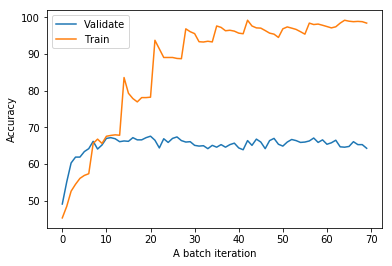

In [103]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

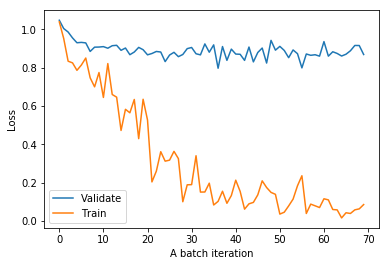

In [104]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# GRU type 2 (n = 300), dp = 0.9

In [105]:
gru = GRU(300,300,dropout = 0.9).cuda()

In [262]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [263]:
criterion = nn.CrossEntropyLoss()

In [264]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=300_t2_dp=0_9',num_epochs=7)

Epoch: [1/7], Step: [101/2500], Validation Acc: 45.125
Epoch: [1/7], Step: [201/2500], Validation Acc: 48.07
Epoch: [1/7], Step: [301/2500], Validation Acc: 50.715
Epoch: [1/7], Step: [401/2500], Validation Acc: 52.935
Epoch: [1/7], Step: [501/2500], Validation Acc: 53.08
Epoch: [1/7], Step: [601/2500], Validation Acc: 55.82
Epoch: [1/7], Step: [701/2500], Validation Acc: 55.885
Epoch: [1/7], Step: [801/2500], Validation Acc: 56.545
Epoch: [1/7], Step: [901/2500], Validation Acc: 56.63
Epoch: [1/7], Step: [1001/2500], Validation Acc: 57.91
Epoch: [1/7], Step: [1101/2500], Validation Acc: 58.35
Epoch: [1/7], Step: [1201/2500], Validation Acc: 59.01
Epoch: [1/7], Step: [1301/2500], Validation Acc: 59.835
Epoch: [1/7], Step: [1401/2500], Validation Acc: 60.03
Epoch: [1/7], Step: [1501/2500], Validation Acc: 53.78
Epoch: [1/7], Step: [1601/2500], Validation Acc: 58.34
Epoch: [1/7], Step: [1701/2500], Validation Acc: 59.775
Epoch: [1/7], Step: [1801/2500], Validation Acc: 60.01
Epoch: [1/7]

Epoch: [7/7], Step: [1501/2500], Validation Acc: 63.48
Epoch: [7/7], Step: [1601/2500], Validation Acc: 63.56
Epoch: [7/7], Step: [1701/2500], Validation Acc: 63.25
Epoch: [7/7], Step: [1801/2500], Validation Acc: 63.625
Epoch: [7/7], Step: [1901/2500], Validation Acc: 63.51
Epoch: [7/7], Step: [2001/2500], Validation Acc: 63.61
Epoch: [7/7], Step: [2101/2500], Validation Acc: 63.095
Epoch: [7/7], Step: [2201/2500], Validation Acc: 63.465
Epoch: [7/7], Step: [2301/2500], Validation Acc: 63.43
Epoch: [7/7], Step: [2401/2500], Validation Acc: 63.015
Best Accuracy:65.755


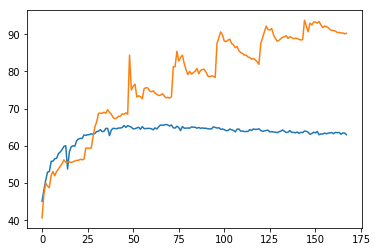

In [265]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')

# GRU type 2 (n = 300), dp = 0.7

In [266]:
gru = GRU(300,300,dropout = 0.7).cuda()

In [267]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [268]:
criterion = nn.CrossEntropyLoss()

In [269]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'gru_hd=300_t2_dp=0_7',num_epochs=7)

Epoch: [1/7], Step: [101/2500], Validation Acc: 46.06
Epoch: [1/7], Step: [201/2500], Validation Acc: 49.505
Epoch: [1/7], Step: [301/2500], Validation Acc: 51.92
Epoch: [1/7], Step: [401/2500], Validation Acc: 54.045
Epoch: [1/7], Step: [501/2500], Validation Acc: 54.875
Epoch: [1/7], Step: [601/2500], Validation Acc: 52.96
Epoch: [1/7], Step: [701/2500], Validation Acc: 56.2
Epoch: [1/7], Step: [801/2500], Validation Acc: 56.865
Epoch: [1/7], Step: [901/2500], Validation Acc: 57.435
Epoch: [1/7], Step: [1001/2500], Validation Acc: 56.81
Epoch: [1/7], Step: [1101/2500], Validation Acc: 57.71
Epoch: [1/7], Step: [1201/2500], Validation Acc: 58.885
Epoch: [1/7], Step: [1301/2500], Validation Acc: 59.42
Epoch: [1/7], Step: [1401/2500], Validation Acc: 59.615
Epoch: [1/7], Step: [1501/2500], Validation Acc: 60.065
Epoch: [1/7], Step: [1601/2500], Validation Acc: 60.45
Epoch: [1/7], Step: [1701/2500], Validation Acc: 60.77
Epoch: [1/7], Step: [1801/2500], Validation Acc: 61.115
Epoch: [1/7

Epoch: [7/7], Step: [601/2500], Validation Acc: 63.22
Epoch: [7/7], Step: [701/2500], Validation Acc: 63.8
Epoch: [7/7], Step: [801/2500], Validation Acc: 63.79
Epoch: [7/7], Step: [901/2500], Validation Acc: 64.07
Epoch: [7/7], Step: [1001/2500], Validation Acc: 63.75
Epoch: [7/7], Step: [1101/2500], Validation Acc: 63.48
Epoch: [7/7], Step: [1201/2500], Validation Acc: 63.75
Epoch: [7/7], Step: [1301/2500], Validation Acc: 64.25
Epoch: [7/7], Step: [1401/2500], Validation Acc: 63.725
Epoch: [7/7], Step: [1501/2500], Validation Acc: 63.69
Epoch: [7/7], Step: [1601/2500], Validation Acc: 63.74
Epoch: [7/7], Step: [1701/2500], Validation Acc: 63.65
Epoch: [7/7], Step: [1801/2500], Validation Acc: 63.05
Epoch: [7/7], Step: [1901/2500], Validation Acc: 63.705
Epoch: [7/7], Step: [2001/2500], Validation Acc: 63.15
Epoch: [7/7], Step: [2101/2500], Validation Acc: 63.45
Epoch: [7/7], Step: [2201/2500], Validation Acc: 63.71
Epoch: [7/7], Step: [2301/2500], Validation Acc: 63.315
Epoch: [7/7]

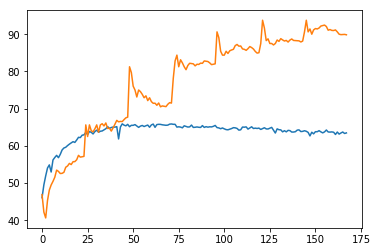

In [270]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')

# Separate GRU for premise and hypothesis

In [106]:
class SepGRU(nn.Module):
    def __init__(self, emb_size, hidden_size, dropout, vocab_size = new_embeddings.shape[0],):
        super(SepGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(new_embeddings).cuda(), freeze = False)
        self.embedding.weight.requires_grad = True
        self.gru1 = nn.GRU(emb_size, hidden_size, 1, batch_first=True, bidirectional = True)
        self.gru2 = nn.GRU(emb_size, hidden_size, 1, batch_first=True, bidirectional = True)
        self.linear1 = nn.Linear(4*hidden_size, 500)
        self.linear2 = nn.Linear(500, 3)
        self.dropout = dropout

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(1*2, batch_size, self.hidden_size).cuda()

        return hidden

    def forward(self, x1,x2,len1,len2,m1,m2):
        # reset hidden state

        batch_size, seq_len = x1.size()

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        # get embedding of characters
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        # pack padded sequence
#         embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, len1.numpy(), batch_first=True)
#         embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, len2.numpy(), batch_first=True)
        # fprop though RNN
        _, h1= self.gru1(embed1, self.hidden1)
        _, h2 = self.gru2(embed2, self.hidden2)
        # undo packing
#         gru_out_1, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_1, batch_first=True)
#         gru_out_2, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out_2, batch_first=True)
        # sum hidden activations of RNN across time
#         gru_out_1 = torch.sum(gru_out_1, dim = 1)
#         gru_out_2 = torch.sum(gru_out_2, dim = 1)
        
#         print(h1.size())
#         print(h2.size())
        h1 = torch.transpose(h1,0,1).contiguous().view(batch_size,-1)
        h2 = torch.transpose(h2,0,1).contiguous().view(batch_size,-1)
        #cat hidden rep
        x = torch.cat([h1,h2],dim = 1)
        x = F.dropout(F.relu(self.linear1(x)),p = self.dropout)
        x = self.linear2(x)
        return x

# Sep GRU n = 300, dropout = 0

In [107]:
gru = SepGRU(300,300,dropout = 0).cuda()

In [108]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, gru.parameters()), lr = 1e-3)

In [109]:
criterion = nn.CrossEntropyLoss()

In [110]:
gru, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(gru,criterion,optimizer,'sep_gru_hd=300_t2_dp=0',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 52.2


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type SepGRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/10], Step: [201/782], Validation Acc: 55.7
Epoch: [1/10], Step: [301/782], Validation Acc: 57.9
Epoch: [1/10], Step: [401/782], Validation Acc: 58.2
Epoch: [1/10], Step: [501/782], Validation Acc: 60.5
Epoch: [1/10], Step: [601/782], Validation Acc: 61.2
Epoch: [1/10], Step: [701/782], Validation Acc: 63.0
Epoch: [2/10], Step: [101/782], Validation Acc: 62.7
Epoch: [2/10], Step: [201/782], Validation Acc: 64.1
Epoch: [2/10], Step: [301/782], Validation Acc: 63.0
Epoch: [2/10], Step: [401/782], Validation Acc: 62.7
Epoch: [2/10], Step: [501/782], Validation Acc: 65.2
Epoch: [2/10], Step: [601/782], Validation Acc: 65.2
Epoch: [2/10], Step: [701/782], Validation Acc: 64.0
Epoch: [3/10], Step: [101/782], Validation Acc: 65.6
Epoch: [3/10], Step: [201/782], Validation Acc: 64.3
Epoch: [3/10], Step: [301/782], Validation Acc: 63.8
Epoch: [3/10], Step: [401/782], Validation Acc: 64.6
Epoch: [3/10], Step: [501/782], Validation Acc: 63.3
Epoch: [3/10], Step: [601/782], Validation Acc

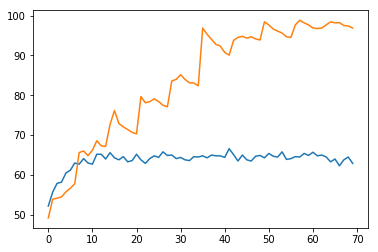

In [111]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')

# 3 correct and 3 incorrect prediction for the best GRU model

The best gru model had following configuration: 400 hidden rep. dimension,interaction type = Element wise multiplication, max sent. len = 50 and dropout = 0. The best GRU model achieves 69.8% accuracy on the validation set.

In [278]:
best_pred_gru = unpickling('/scratch/ark576/NLP_HW_2/gru_hd=400_t2_dp=0_max_len=50_multh_200k_preds')

In [392]:
correct_preds = best_pred_gru[best_pred_gru[:,1] == best_pred_gru[:,2]]

In [393]:
filtered_correct_df = val_data.loc[correct_preds[:,0]]

In [405]:
correct_preds_text = correct_preds.astype(str)
correct_preds_text[correct_preds_text[:,1]=='0'] = 'contradiction'
correct_preds_text[correct_preds_text[:,1]=='1'] = 'neutral'
correct_preds_text[correct_preds_text[:,1]=='2'] = 'entailment'
idx = correct_preds[:,0]
# np.random.shuffle(idx)
for j,i in enumerate(idx[:10]):
    print(i)
    print('-'*50)
    print('Sentence 1:',filtered_correct_df.iloc[j]['sentence1'])
    print('Sentence 2:',filtered_correct_df.iloc[j]['sentence2'])
    print('Label:',filtered_correct_df.iloc[j]['label'] )
    print('Predicted Label:',correct_preds_text[correct_preds[:,0] == i][0,1])
    print('='*50)

647
--------------------------------------------------
Sentence 1: Three women , two wearing red shirts and one wearing a purple shirt , and a man , wearing a light blue shirt , jump on a basketball court with balls in their hands .
Sentence 2: Three people 's are eating in hotel .
Label: contradiction
Predicted Label: contradiction
389
--------------------------------------------------
Sentence 1: Two men on a basketball court one in white and red the other in blue , the player in white is throwing the ball in while teammates look on .
Sentence 2: The men are playing basketball .
Label: entailment
Predicted Label: entailment
479
--------------------------------------------------
Sentence 1: A man with an open shirt and glasses holding a microphone and another man in a bowler hat and plaid suit using a bow on an instrument .
Sentence 2: The singer and musician are in the bathroom .
Label: contradiction
Predicted Label: contradiction
29
--------------------------------------------------

In [401]:
incorrect_preds = best_pred_gru[best_pred_gru[:,1] != best_pred_gru[:,2]]

In [402]:
filtered_incorrect_df = val_data.iloc[incorrect_preds[:,0]]

In [406]:
incorrect_preds_text = incorrect_preds.astype(str)
incorrect_preds_text[incorrect_preds_text[:,1]=='0'] = 'contradiction'
incorrect_preds_text[incorrect_preds_text[:,1]=='1'] = 'neutral'
incorrect_preds_text[incorrect_preds_text[:,1]=='2'] = 'entailment'
idx = incorrect_preds[:,0]
# np.random.shuffle(idx)
for j,i in enumerate(idx[:10]):
    print(i)
    print('-'*50)
    print('Sentence 1:',filtered_incorrect_df.iloc[j]['sentence1'])
    print('Sentence 2:',filtered_incorrect_df.iloc[j]['sentence2'])
    print('Label:',filtered_incorrect_df.iloc[j]['label'] )
    print('Predicted Label:',incorrect_preds_text[incorrect_preds[:,0] == i][0,1])
    print('='*50)

903
--------------------------------------------------
Sentence 1: A man in a brown jacket , white shirt , and dark slacks is holding a book with his finger on the page while sitting on a wooden floor , and leaning against a yellow wall with a door on one side and cloths on hangers on the other side .
Sentence 2: A man sits on a wooden floor building a model ship .
Label: contradiction
Predicted Label: neutral
650
--------------------------------------------------
Sentence 1: A young man , without apparent protective gear , is on a bicycle jumping over small hills of sand or gravel , with a long bridge and tall buildings in the background .
Sentence 2: A young male is riding his bicycle over small hills .
Label: entailment
Predicted Label: neutral
431
--------------------------------------------------
Sentence 1: A man with a beard , curly hair and a beard wearing a green shirt and navy blue jacket standing still looking through his red sunglasses .
Sentence 2: A man is crouched down .

# CNN

In [89]:
class CNN(nn.Module):
    def __init__(self, hidden_size,ks , emb_size = 300, vocab_size = new_embeddings.shape[0]):

        super(CNN, self).__init__()

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(new_embeddings).cuda(), freeze = False)
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=ks, padding=int((ks-1)/2))
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=ks, padding=int((ks-1)/2))

        self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)

    def forward(self,x1,x2,len1,len2,m1,m2):
        batch_size, seq_len1 = x1.size()
        batch_size, seq_len2 = x1.size()
        embed1 = self.embedding(x1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        
        embed2 = self.embedding(x2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
        
        hidden1 = F.max_pool1d(hidden1.transpose(1,2), seq_len1).squeeze()
        hidden2 = F.max_pool1d(hidden2.transpose(1,2), seq_len1).squeeze()
        x = torch.cat([hidden1,hidden2],dim = 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# CNN (ks = 3, filters = 300, cating h)

In [71]:
cnn = CNN(300,3).cuda()

In [72]:
count_parameters(cnn) - 20522*300

722103

In [115]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [116]:
criterion = nn.CrossEntropyLoss()

In [117]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=300_ks=3_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 54.1


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/10], Step: [201/782], Validation Acc: 57.0
Epoch: [1/10], Step: [301/782], Validation Acc: 53.3
Epoch: [1/10], Step: [401/782], Validation Acc: 57.8
Epoch: [1/10], Step: [501/782], Validation Acc: 59.5
Epoch: [1/10], Step: [601/782], Validation Acc: 60.7
Epoch: [1/10], Step: [701/782], Validation Acc: 59.9
Epoch: [2/10], Step: [101/782], Validation Acc: 59.1
Epoch: [2/10], Step: [201/782], Validation Acc: 61.3
Epoch: [2/10], Step: [301/782], Validation Acc: 62.0
Epoch: [2/10], Step: [401/782], Validation Acc: 62.2
Epoch: [2/10], Step: [501/782], Validation Acc: 62.6
Epoch: [2/10], Step: [601/782], Validation Acc: 62.9
Epoch: [2/10], Step: [701/782], Validation Acc: 62.3
Epoch: [3/10], Step: [101/782], Validation Acc: 62.8
Epoch: [3/10], Step: [201/782], Validation Acc: 62.8
Epoch: [3/10], Step: [301/782], Validation Acc: 63.3
Epoch: [3/10], Step: [401/782], Validation Acc: 62.9
Epoch: [3/10], Step: [501/782], Validation Acc: 63.7
Epoch: [3/10], Step: [601/782], Validation Acc

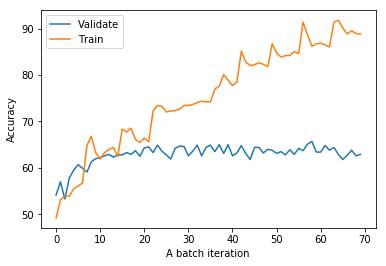

In [118]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

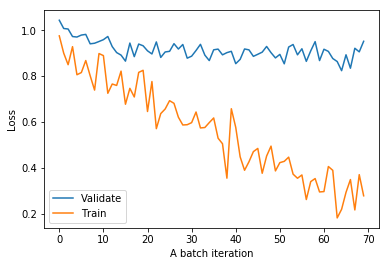

In [119]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN (ks = 7, filters = 300, cath)

In [74]:
cnn = CNN(300,7).cuda()

In [75]:
count_parameters(cnn) - 20522*300

1442103

In [122]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [123]:
criterion = nn.CrossEntropyLoss()

In [124]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=300_ks=7_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 54.3
Epoch: [1/10], Step: [201/782], Validation Acc: 54.9
Epoch: [1/10], Step: [301/782], Validation Acc: 53.9
Epoch: [1/10], Step: [401/782], Validation Acc: 56.3
Epoch: [1/10], Step: [501/782], Validation Acc: 56.6
Epoch: [1/10], Step: [601/782], Validation Acc: 57.3
Epoch: [1/10], Step: [701/782], Validation Acc: 57.5
Epoch: [2/10], Step: [101/782], Validation Acc: 58.7
Epoch: [2/10], Step: [201/782], Validation Acc: 59.8
Epoch: [2/10], Step: [301/782], Validation Acc: 61.0
Epoch: [2/10], Step: [401/782], Validation Acc: 59.2
Epoch: [2/10], Step: [501/782], Validation Acc: 60.0
Epoch: [2/10], Step: [601/782], Validation Acc: 58.1
Epoch: [2/10], Step: [701/782], Validation Acc: 60.5
Epoch: [3/10], Step: [101/782], Validation Acc: 60.4
Epoch: [3/10], Step: [201/782], Validation Acc: 59.5
Epoch: [3/10], Step: [301/782], Validation Acc: 61.9
Epoch: [3/10], Step: [401/782], Validation Acc: 61.7
Epoch: [3/10], Step: [501/782], Validation Acc

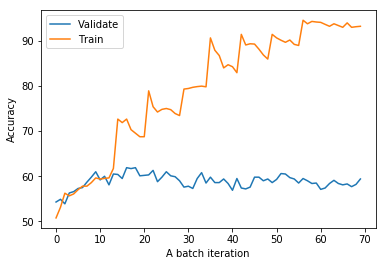

In [125]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

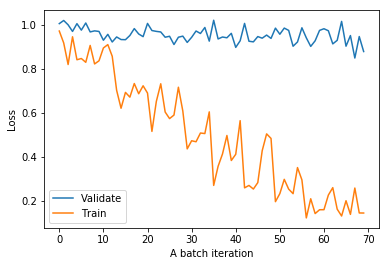

In [126]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN (ks = 5, filters = 300, cath)

In [76]:
cnn = CNN(300,5).cuda()

In [77]:
count_parameters(cnn) - 20522*300

1082103

In [129]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [130]:
criterion = nn.CrossEntropyLoss()

In [131]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=300_ks=5_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 51.1
Epoch: [1/10], Step: [201/782], Validation Acc: 54.0
Epoch: [1/10], Step: [301/782], Validation Acc: 54.8
Epoch: [1/10], Step: [401/782], Validation Acc: 58.5
Epoch: [1/10], Step: [501/782], Validation Acc: 58.2
Epoch: [1/10], Step: [601/782], Validation Acc: 57.0
Epoch: [1/10], Step: [701/782], Validation Acc: 57.5
Epoch: [2/10], Step: [101/782], Validation Acc: 57.6
Epoch: [2/10], Step: [201/782], Validation Acc: 56.9
Epoch: [2/10], Step: [301/782], Validation Acc: 58.8
Epoch: [2/10], Step: [401/782], Validation Acc: 59.5
Epoch: [2/10], Step: [501/782], Validation Acc: 57.3
Epoch: [2/10], Step: [601/782], Validation Acc: 61.1
Epoch: [2/10], Step: [701/782], Validation Acc: 60.0
Epoch: [3/10], Step: [101/782], Validation Acc: 60.0
Epoch: [3/10], Step: [201/782], Validation Acc: 60.2
Epoch: [3/10], Step: [301/782], Validation Acc: 61.3
Epoch: [3/10], Step: [401/782], Validation Acc: 60.3
Epoch: [3/10], Step: [501/782], Validation Acc

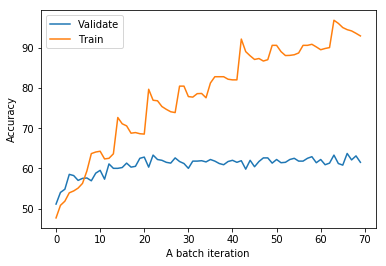

In [132]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

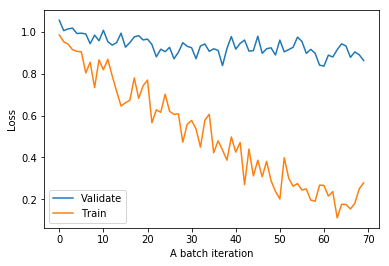

In [133]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN (ks = 3, filters = 400, cath)

In [78]:
cnn = CNN(400,3).cuda()

In [79]:
count_parameters(cnn) - 20522*300

1162703

In [136]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [137]:
criterion = nn.CrossEntropyLoss()

In [138]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=400_ks=3_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 53.7
Epoch: [1/10], Step: [201/782], Validation Acc: 59.4
Epoch: [1/10], Step: [301/782], Validation Acc: 60.1
Epoch: [1/10], Step: [401/782], Validation Acc: 59.7
Epoch: [1/10], Step: [501/782], Validation Acc: 60.1
Epoch: [1/10], Step: [601/782], Validation Acc: 60.5
Epoch: [1/10], Step: [701/782], Validation Acc: 59.1
Epoch: [2/10], Step: [101/782], Validation Acc: 60.8
Epoch: [2/10], Step: [201/782], Validation Acc: 62.7
Epoch: [2/10], Step: [301/782], Validation Acc: 62.0
Epoch: [2/10], Step: [401/782], Validation Acc: 63.5
Epoch: [2/10], Step: [501/782], Validation Acc: 62.9
Epoch: [2/10], Step: [601/782], Validation Acc: 63.1
Epoch: [2/10], Step: [701/782], Validation Acc: 64.4
Epoch: [3/10], Step: [101/782], Validation Acc: 62.7
Epoch: [3/10], Step: [201/782], Validation Acc: 64.4
Epoch: [3/10], Step: [301/782], Validation Acc: 63.1
Epoch: [3/10], Step: [401/782], Validation Acc: 63.9
Epoch: [3/10], Step: [501/782], Validation Acc

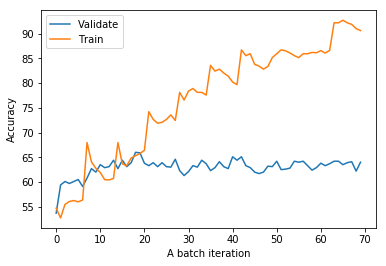

In [139]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

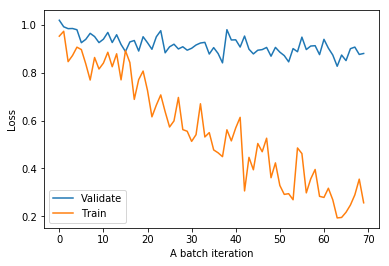

In [140]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN (ks = 3, filters = 500, cath)

In [80]:
cnn = CNN(500,3).cuda()

In [81]:
count_parameters(cnn) - 20522*300

1703303

In [143]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [144]:
criterion = nn.CrossEntropyLoss()

In [145]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=500_ks=3_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 51.6
Epoch: [1/10], Step: [201/782], Validation Acc: 55.4
Epoch: [1/10], Step: [301/782], Validation Acc: 55.7
Epoch: [1/10], Step: [401/782], Validation Acc: 57.1
Epoch: [1/10], Step: [501/782], Validation Acc: 59.6
Epoch: [1/10], Step: [601/782], Validation Acc: 60.4
Epoch: [1/10], Step: [701/782], Validation Acc: 62.2
Epoch: [2/10], Step: [101/782], Validation Acc: 61.9
Epoch: [2/10], Step: [201/782], Validation Acc: 60.2
Epoch: [2/10], Step: [301/782], Validation Acc: 61.4
Epoch: [2/10], Step: [401/782], Validation Acc: 60.9
Epoch: [2/10], Step: [501/782], Validation Acc: 62.7
Epoch: [2/10], Step: [601/782], Validation Acc: 62.9
Epoch: [2/10], Step: [701/782], Validation Acc: 63.7
Epoch: [3/10], Step: [101/782], Validation Acc: 63.9
Epoch: [3/10], Step: [201/782], Validation Acc: 62.6
Epoch: [3/10], Step: [301/782], Validation Acc: 63.6
Epoch: [3/10], Step: [401/782], Validation Acc: 63.9
Epoch: [3/10], Step: [501/782], Validation Acc

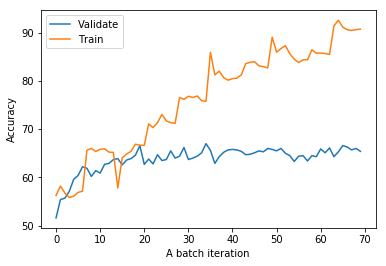

In [146]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

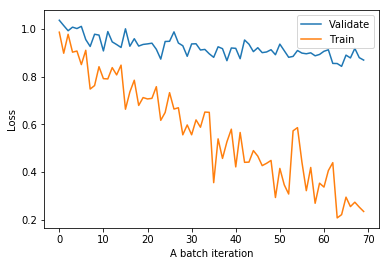

In [147]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN (ks = 3, filters = 600, cath)

In [97]:
cnn = CNN(600,3).cuda()

In [98]:
count_parameters(cnn) - 20522*300

2343903

In [99]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [100]:
criterion = nn.CrossEntropyLoss()

In [101]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=600_ks=3_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 53.1
Epoch: [1/10], Step: [201/782], Validation Acc: 55.8
Epoch: [1/10], Step: [301/782], Validation Acc: 56.1
Epoch: [1/10], Step: [401/782], Validation Acc: 58.6
Epoch: [1/10], Step: [501/782], Validation Acc: 58.6
Epoch: [1/10], Step: [601/782], Validation Acc: 58.8
Epoch: [1/10], Step: [701/782], Validation Acc: 60.0
Epoch: [2/10], Step: [101/782], Validation Acc: 60.1
Epoch: [2/10], Step: [201/782], Validation Acc: 59.9
Epoch: [2/10], Step: [301/782], Validation Acc: 60.1
Epoch: [2/10], Step: [401/782], Validation Acc: 61.0
Epoch: [2/10], Step: [501/782], Validation Acc: 61.2
Epoch: [2/10], Step: [601/782], Validation Acc: 62.3
Epoch: [2/10], Step: [701/782], Validation Acc: 60.7
Epoch: [3/10], Step: [101/782], Validation Acc: 59.9
Epoch: [3/10], Step: [201/782], Validation Acc: 61.9
Epoch: [3/10], Step: [301/782], Validation Acc: 61.3
Epoch: [3/10], Step: [401/782], Validation Acc: 61.4
Epoch: [3/10], Step: [501/782], Validation Acc

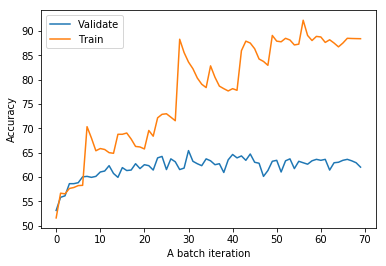

In [102]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

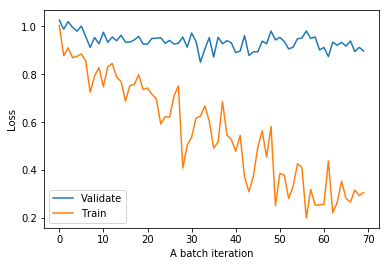

In [103]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN (ks = 3, filters = 700, cath)

In [90]:
cnn = CNN(700,3).cuda()

In [91]:
count_parameters(cnn) - 20522*300

3084503

In [92]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [93]:
criterion = nn.CrossEntropyLoss()

In [94]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=700_ks=3_cath',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 53.5


/home/ark576/.conda/envs/nlp/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1/10], Step: [201/782], Validation Acc: 54.5
Epoch: [1/10], Step: [301/782], Validation Acc: 56.5
Epoch: [1/10], Step: [401/782], Validation Acc: 56.1
Epoch: [1/10], Step: [501/782], Validation Acc: 57.3
Epoch: [1/10], Step: [601/782], Validation Acc: 61.6
Epoch: [1/10], Step: [701/782], Validation Acc: 58.3
Epoch: [2/10], Step: [101/782], Validation Acc: 61.0
Epoch: [2/10], Step: [201/782], Validation Acc: 59.6
Epoch: [2/10], Step: [301/782], Validation Acc: 61.7
Epoch: [2/10], Step: [401/782], Validation Acc: 62.0
Epoch: [2/10], Step: [501/782], Validation Acc: 62.6
Epoch: [2/10], Step: [601/782], Validation Acc: 62.1
Epoch: [2/10], Step: [701/782], Validation Acc: 61.4
Epoch: [3/10], Step: [101/782], Validation Acc: 61.6
Epoch: [3/10], Step: [201/782], Validation Acc: 63.5
Epoch: [3/10], Step: [301/782], Validation Acc: 63.4
Epoch: [3/10], Step: [401/782], Validation Acc: 62.8
Epoch: [3/10], Step: [501/782], Validation Acc: 62.7
Epoch: [3/10], Step: [601/782], Validation Acc

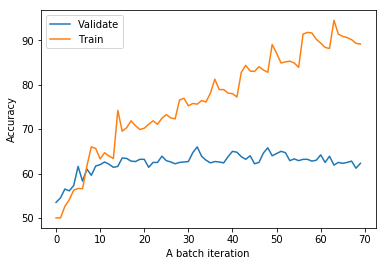

In [95]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

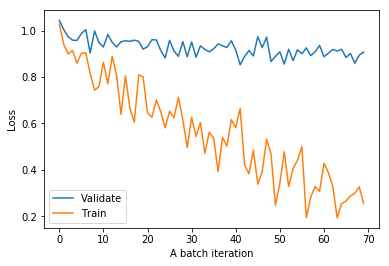

In [96]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN Elemnent wise multiplication

In [82]:
class CNN(nn.Module):
    def __init__(self, hidden_size,ks , emb_size = 300, vocab_size = new_embeddings.shape[0]):

        super(CNN, self).__init__()

        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        self.embedding.from_pretrained(torch.from_numpy(new_embeddings).cuda(), freeze = False)
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=ks, padding=int((ks-1)/2))
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=ks, padding=int((ks-1)/2))

        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 3)

    def forward(self,x1,x2,len1,len2,m1,m2):
        batch_size, seq_len1 = x1.size()
        batch_size, seq_len2 = x1.size()
        embed1 = self.embedding(x1)
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
        
        embed2 = self.embedding(x2)
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))
        
        hidden1 = F.max_pool1d(hidden1.transpose(1,2), seq_len1).squeeze()
        hidden2 = F.max_pool1d(hidden2.transpose(1,2), seq_len1).squeeze()
        x = hidden1*hidden2
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

# CNN (ks = 3, filters = 300, multh)

In [83]:
cnn = CNN(300,3).cuda()

In [84]:
count_parameters(cnn) - 20522*300

632103

In [151]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [152]:
criterion = nn.CrossEntropyLoss()

In [153]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=300_ks=3_multh',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 46.8
Epoch: [1/10], Step: [201/782], Validation Acc: 51.1
Epoch: [1/10], Step: [301/782], Validation Acc: 53.2
Epoch: [1/10], Step: [401/782], Validation Acc: 54.4
Epoch: [1/10], Step: [501/782], Validation Acc: 53.1
Epoch: [1/10], Step: [601/782], Validation Acc: 51.7
Epoch: [1/10], Step: [701/782], Validation Acc: 56.0
Epoch: [2/10], Step: [101/782], Validation Acc: 54.0
Epoch: [2/10], Step: [201/782], Validation Acc: 55.1
Epoch: [2/10], Step: [301/782], Validation Acc: 55.2
Epoch: [2/10], Step: [401/782], Validation Acc: 54.3
Epoch: [2/10], Step: [501/782], Validation Acc: 53.3
Epoch: [2/10], Step: [601/782], Validation Acc: 56.0
Epoch: [2/10], Step: [701/782], Validation Acc: 55.8
Epoch: [3/10], Step: [101/782], Validation Acc: 56.9
Epoch: [3/10], Step: [201/782], Validation Acc: 57.0
Epoch: [3/10], Step: [301/782], Validation Acc: 55.3
Epoch: [3/10], Step: [401/782], Validation Acc: 55.9
Epoch: [3/10], Step: [501/782], Validation Acc

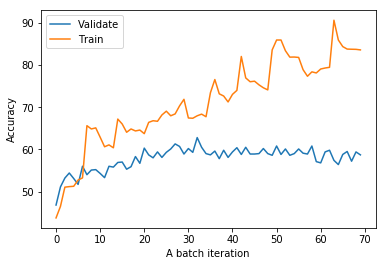

In [154]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

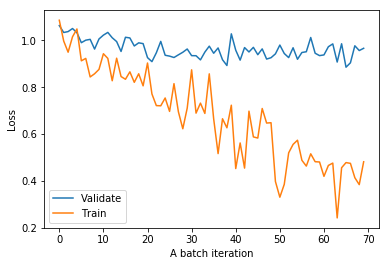

In [155]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN (ks = 3, filters = 400, multh)

In [85]:
cnn = CNN(400,3).cuda()

In [86]:
count_parameters(cnn) - 20522*300

1002703

In [158]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [159]:
criterion = nn.CrossEntropyLoss()

In [160]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=400_ks=3_multh',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 48.4
Epoch: [1/10], Step: [201/782], Validation Acc: 51.3
Epoch: [1/10], Step: [301/782], Validation Acc: 49.1
Epoch: [1/10], Step: [401/782], Validation Acc: 55.3
Epoch: [1/10], Step: [501/782], Validation Acc: 55.3
Epoch: [1/10], Step: [601/782], Validation Acc: 54.7
Epoch: [1/10], Step: [701/782], Validation Acc: 55.1
Epoch: [2/10], Step: [101/782], Validation Acc: 53.1
Epoch: [2/10], Step: [201/782], Validation Acc: 55.9
Epoch: [2/10], Step: [301/782], Validation Acc: 55.8
Epoch: [2/10], Step: [401/782], Validation Acc: 57.7
Epoch: [2/10], Step: [501/782], Validation Acc: 57.6
Epoch: [2/10], Step: [601/782], Validation Acc: 59.2
Epoch: [2/10], Step: [701/782], Validation Acc: 57.6
Epoch: [3/10], Step: [101/782], Validation Acc: 59.3
Epoch: [3/10], Step: [201/782], Validation Acc: 58.0
Epoch: [3/10], Step: [301/782], Validation Acc: 57.1
Epoch: [3/10], Step: [401/782], Validation Acc: 59.1
Epoch: [3/10], Step: [501/782], Validation Acc

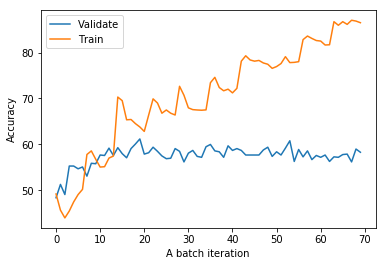

In [161]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

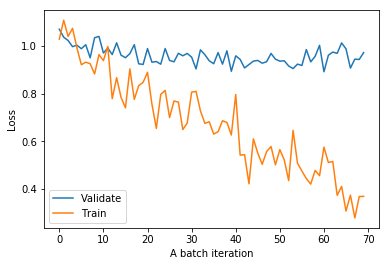

In [162]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# CNN (ks = 3, filters = 500, multh)

In [87]:
cnn = CNN(500,3).cuda()

In [88]:
count_parameters(cnn) - 20522*300

1453303

In [165]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

In [166]:
criterion = nn.CrossEntropyLoss()

In [167]:
cnn, loss_dict_gru, acc_dict_gru, best_pred_gru = train_model(cnn,criterion,optimizer,'cnn_hd=500_ks=3_multh',num_epochs=10)

Epoch: [1/10], Step: [101/782], Validation Acc: 43.5
Epoch: [1/10], Step: [201/782], Validation Acc: 53.0
Epoch: [1/10], Step: [301/782], Validation Acc: 52.8
Epoch: [1/10], Step: [401/782], Validation Acc: 54.0
Epoch: [1/10], Step: [501/782], Validation Acc: 54.7
Epoch: [1/10], Step: [601/782], Validation Acc: 54.1
Epoch: [1/10], Step: [701/782], Validation Acc: 54.0
Epoch: [2/10], Step: [101/782], Validation Acc: 56.1
Epoch: [2/10], Step: [201/782], Validation Acc: 55.7
Epoch: [2/10], Step: [301/782], Validation Acc: 57.8
Epoch: [2/10], Step: [401/782], Validation Acc: 56.4
Epoch: [2/10], Step: [501/782], Validation Acc: 56.4
Epoch: [2/10], Step: [601/782], Validation Acc: 55.3
Epoch: [2/10], Step: [701/782], Validation Acc: 57.6
Epoch: [3/10], Step: [101/782], Validation Acc: 58.7
Epoch: [3/10], Step: [201/782], Validation Acc: 59.3
Epoch: [3/10], Step: [301/782], Validation Acc: 57.7
Epoch: [3/10], Step: [401/782], Validation Acc: 56.8
Epoch: [3/10], Step: [501/782], Validation Acc

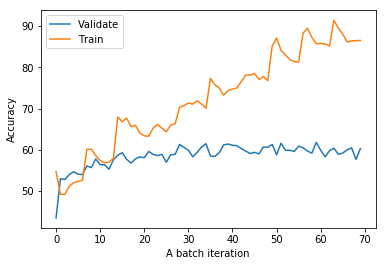

In [168]:
plt.plot(acc_dict_gru['val'], label = 'Validate')
plt.plot(acc_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Accuracy')
plt.legend()

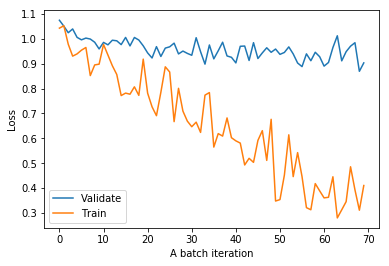

In [169]:
plt.plot(loss_dict_gru['val'], label = 'Validate')
plt.plot(loss_dict_gru['train'], label = 'Train')
plt.xlabel('A batch iteration')
plt.ylabel('Loss')
plt.legend()

# 3 correct and 3 incorrect prediction for the best CNN model

The best cnn model had following configuration: 500 hidden rep. dimension,interaction type = Concatenation, kernel size = 3,  max sent. len = 50 and dropout = 0. The best CNN model achieves 67% accuracy on the validation set.

In [414]:
best_pred_cnn = unpickling('/scratch/ark576/NLP_HW_2/cnn_hd=500_ks=3_cath_200k_preds')

In [415]:
correct_preds = best_pred_gru[best_pred_gru[:,1] == best_pred_gru[:,2]]

In [416]:
filtered_correct_df = val_data.loc[correct_preds[:,0]]

In [417]:
correct_preds_text = correct_preds.astype(str)
correct_preds_text[correct_preds_text[:,1]=='0'] = 'contradiction'
correct_preds_text[correct_preds_text[:,1]=='1'] = 'neutral'
correct_preds_text[correct_preds_text[:,1]=='2'] = 'entailment'
idx = correct_preds[:,0]
# np.random.shuffle(idx)
for j,i in enumerate(idx[:10]):
    print(i)
    print('-'*50)
    print('Sentence 1:',filtered_correct_df.iloc[j]['sentence1'])
    print('Sentence 2:',filtered_correct_df.iloc[j]['sentence2'])
    print('Label:',filtered_correct_df.iloc[j]['label'] )
    print('Predicted Label:',correct_preds_text[correct_preds[:,0] == i][0,1])
    print('='*50)

366
--------------------------------------------------
Sentence 1: An Asian man is standing on a rusty dock surrounded by ropes and tires and is sticking a fishing pole into the water in front of him .
Sentence 2: A fisherman is working hard on the dock
Label: neutral
Predicted Label: neutral
223
--------------------------------------------------
Sentence 1: As a referee looks on , a Los Angeles baseball player is falling over the top of a rival player who is just sliding into base .
Sentence 2: The people are playing basketball .
Label: contradiction
Predicted Label: contradiction
29
--------------------------------------------------
Sentence 1: Three cheerful ladies sitting at a table doing a yarn work in a room , at the background are similar groups of ladies doing similar work .
Sentence 2: The ladies are discussing what they are going to do tonight .
Label: neutral
Predicted Label: neutral
741
--------------------------------------------------
Sentence 1: Woman in light blue knit 

In [418]:
incorrect_preds = best_pred_gru[best_pred_gru[:,1] != best_pred_gru[:,2]]

In [419]:
filtered_incorrect_df = val_data.iloc[incorrect_preds[:,0]]

In [420]:
incorrect_preds_text = incorrect_preds.astype(str)
incorrect_preds_text[incorrect_preds_text[:,1]=='0'] = 'contradiction'
incorrect_preds_text[incorrect_preds_text[:,1]=='1'] = 'neutral'
incorrect_preds_text[incorrect_preds_text[:,1]=='2'] = 'entailment'
idx = incorrect_preds[:,0]
# np.random.shuffle(idx)
for j,i in enumerate(idx[:10]):
    print(i)
    print('-'*50)
    print('Sentence 1:',filtered_incorrect_df.iloc[j]['sentence1'])
    print('Sentence 2:',filtered_incorrect_df.iloc[j]['sentence2'])
    print('Label:',filtered_incorrect_df.iloc[j]['label'] )
    print('Predicted Label:',incorrect_preds_text[incorrect_preds[:,0] == i][0,1])
    print('='*50)

783
--------------------------------------------------
Sentence 1: A kid in a red and black coat is laying on his back in the snow with his arm in the air and a red sled is next to him .
Sentence 2: It is a cold day .
Label: entailment
Predicted Label: neutral
17
--------------------------------------------------
Sentence 1: A group of people dressed in Santa Claus suits are looking towards an audience while a DJ runs a sound board and another person throws green balls into the air .
Sentence 2: A band plays at a beach party .
Label: neutral
Predicted Label: contradiction
913
--------------------------------------------------
Sentence 1: Three sisters , barefoot in pink dresses and who range in age from preschool to teenager are pictured on a beach as they look out at the Ocean .
Sentence 2: Three sisters , barefoot in pink dresses and who range in age from preschool to teenager
Label: entailment
Predicted Label: contradiction
629
--------------------------------------------------
Sent